**target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive) --> 79999 : 0 : 80000

**ids**: The id of the tweet ( 2087)

**date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

**flag**: The query (lyx). If there is no query, then this value is NO_QUERY. --> ALL : NO_QUERY

**user**: the user that tweeted (robotickilldozr)

**text**: the text of the tweet (Lyx is cool)

In [1]:
import pandas as pd
from multiprocessing import Pool, Process, Queue, current_process, parent_process
from datetime import datetime
import time 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

In [2]:
m5_data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)

In [3]:
m5_data.columns = col_name =['target', 'ids', 'date', 'flag', 'user', 'text']

In [4]:
for col in col_name:
    print(m5_data[col].unique())

[0 4]
[1467810369 1467810672 1467810917 ... 2193601991 2193602064 2193602129]
['Mon Apr 06 22:19:45 PDT 2009' 'Mon Apr 06 22:19:49 PDT 2009'
 'Mon Apr 06 22:19:53 PDT 2009' ... 'Tue Jun 16 08:38:58 PDT 2009'
 'Tue Jun 16 08:39:00 PDT 2009' 'Tue Jun 16 08:40:50 PDT 2009']
['NO_QUERY']
['_TheSpecialOne_' 'scotthamilton' 'mattycus' ... 'EvolveTom'
 'AmandaMarie1028' 'bpbabe']
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 ... 'Are you ready for your MoJo Makeover? Ask me for details '
 'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur '
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']


## 분석 결과 : 
* neutral sentiment는 없다.
* 'flag' 항목은 drop 가능
* *부정이 긍정보다 1개 더 많음 -> 그럼 1599999개인데 남은 하나는 어디에...?* -> 불러올 때 컬럼이 되었고 컬럼 지정하며 날라감 -> 해결
  * 1~800,000 라인 = 긍정, 그 뒤로 부정

In [5]:
pn = m5_data['target'].value_counts()
pn

target
0    800000
4    800000
Name: count, dtype: int64

In [6]:

m5_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 전처리 함수

In [4]:
def remove_stopwords(text):
    """WordCloud STOPWORDS를 사용해 불용어 제거"""
    stopwords = set(STOPWORDS)  # WordCloud의 STOPWORDS 집합 가져오기
    words = text.split()  # 텍스트를 단어로 분리
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)  # 단어를 다시 합치기

In [5]:
def preprocess(txt: str) -> str:
    """
    Preprocess Twitter text data.
    Args: txt (str): Original text from a tweet
    Return: (str): Cleaned and preprocessed text
    1. 링크형 텍스트 삭제
    2. @~~ 삭제
    3. 문장부호 삭제 (연속된 마침표 등등) —> You’re 같은게 깨져버리는지 유의 (보통 불용어로 처리되어 있음)
    4. &amp &quot &gt &lt —> 삭제
    5. 텍스트 이모티콘은 어떻게??  :), ;),  ^^, ~_~, 등등
    6. 안보이는 이스케이프 문자? (57915 라인에 존재) —> 제로 너비 문자?인 듯
    """
    # 0. 텍스트 이모티콘 처리 (보존)
    # 이모티콘 패턴
    emoji_pattern = r"[:;=8][-~]?[)D\(\[\]pP]|[\^]{2,}|~_~|T_T|xD|<3|:-?o|:-?O"
    emojis = re.findall(emoji_pattern, txt)  # 이모티콘 추출
    txt = re.sub(emoji_pattern, " ", txt)    # 원문에서 제거 후 보존

    # 1. 링크형 텍스트 삭제
    txt = re.sub(r"http\S+|www.\S+|https\S+", "", txt, flags=re.MULTILINE)
    
    # 2. @twitter_id 삭제
    txt = re.sub(r"@\w+", "", txt)
    
    # 3. 문장부호 삭제 (연속된 마침표 포함)
    txt = re.sub(r"[.,!?;:'\"()\[\]{}\-—…]+", " ", txt)
    
    # 4. 특수 HTML 엔티티 삭제
    txt = re.sub(r"&amp|&quot|&gt|&lt|&nbsp;", "", txt)
    
    # 5. 깨진 이스케이프 문자 및 공백 제거
    txt = re.sub(r"[\u200B-\u200D\uFEFF]", "", txt)  # Zero-width 문자 제거
    txt = re.sub(r"\s+", " ", txt).strip()           # 중복 공백 제거
    
    # 최종 클린 텍스트 생성
    return " ".join(txt.split() + emojis)

# 테스트 데이터
tweet = "Hello @user! Check this out: https://example.com 😊 😊 ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com"

# 결과 출력
print("Original text: ", tweet)
print("Preprocessed txt: ", preprocess(tweet))


Original text:  Hello @user! Check this out: https://example.com 😊 😊 ^^ T_T ~_~ &amp; Goodbye... !!! www.google.com
Preprocessed txt:  Hello Check this out 😊 😊 Goodbye ^^ T_T ~_~


### 긍정 / 부정 데이터 분리

In [6]:
pos_data = m5_data[m5_data['target']==4][['text']]
neg_data = m5_data[m5_data['target']==0][['text']]

In [7]:
len(pos_data)==len(neg_data)==800_000

True

In [8]:
pos_data.head()

,text
800000,I LOVE @Health4UandPets u guys r the best!!
800001,im meeting up with one of my besties tonight! ...
800002,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,Being sick can be really cheap when it hurts t...
800004,@LovesBrooklyn2 he has that effect on everyone


## 분산 처리

with Pool

In [11]:
def preprocess_chunk(chunk):
    """데이터프레임의 특정 청크에 preprocess 적용"""
    return chunk.apply(preprocess)

def parallel_apply_pool(func, data, workers=2):
    """Pool을 이용한 병렬 처리"""
    # 데이터를 청크로 나눔
    chunk_size = len(data) // workers
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    with Pool(processes=workers) as pool:
        results = pool.map(func, chunks)
    return pd.concat(results)

In [12]:
# Jupyter Notebook에서 실행
if __name__ == "__main__":
    df = pd.DataFrame({
        'text': [
            "Hello @user! Check this out: https://example.com 😊",
            "What a beautiful day! #amazing",
            "Happy coding everyone :) !!!"
        ]
    })

    df['processed_text'] = parallel_apply_pool(preprocess_chunk, df['text'])
    print(df)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'preprocess_chunk' on <module '__main__' (built-in)>
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/admin/.pyenv/versions/3.11.11/lib/python3.1

KeyboardInterrupt: 

In [9]:
import numpy as np

In [10]:
vectorized_stopwords = np.vectorize(remove_stopwords)
vectorized_process = np.vectorize(preprocess)
pos_data['text'] = vectorized_stopwords(pos_data['text'])
pos_data['text'] = vectorized_process(pos_data['text'])

neg_data['text'] = vectorized_stopwords(neg_data['text'])
neg_data['text'] = vectorized_process(neg_data['text'])
# 17.1 sec

In [11]:
neg_data.head()

,text
0,Awww bummer shoulda got David Carr Third Day i...
1,upset update Facebook texting it might cry res...
2,dived many times ball Managed save 50% rest go...
3,whole body feels itchy fire
4,no behaving all mad here see there


In [12]:
wc = WordCloud()

In [14]:
pos_txt = ' '.join(pos_data['text'])

In [15]:
pos_dict = wc.generate(pos_txt).words_

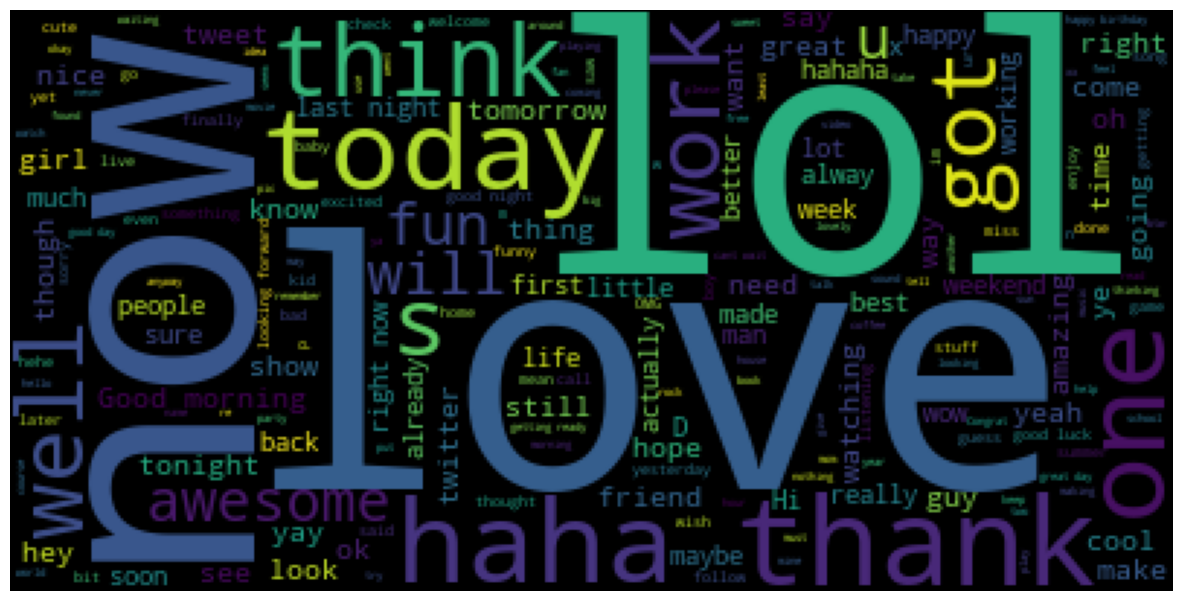

In [16]:
plt.figure(figsize=(15,10))
plt.imshow(WordCloud(max_words=200).generate(pos_txt))   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
plt.axis('off')  #눈금 삭제 
plt.show()


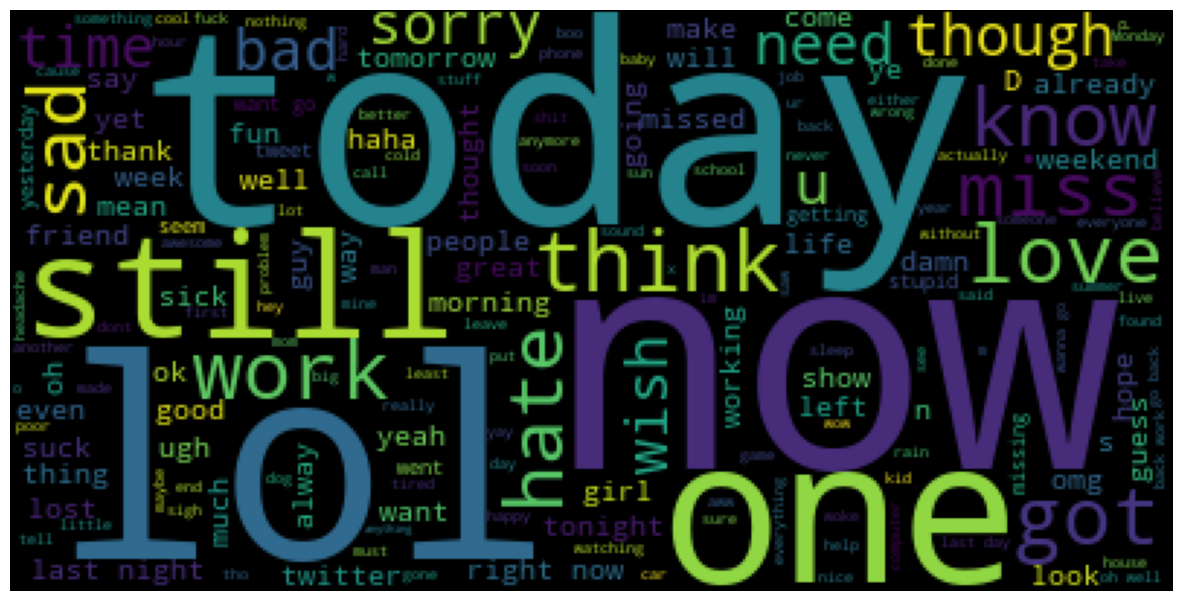

In [17]:
neg_txt = ' '.join(neg_data['text'])
plt.figure(figsize=(15,10))
plt.imshow(WordCloud(max_words=200).generate(neg_txt))   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
plt.axis('off')  #눈금 삭제 
plt.show()

In [18]:
neg_dict = wc.generate(neg_txt).words_

In [19]:
neg_dict

{'now': 1.0,
 'today': 0.8584283143371326,
 'lol': 0.8554889022195561,
 'one': 0.7566886622675465,
 'still': 0.7360527894421116,
 'think': 0.6854829034193162,
 'got': 0.6424115176964607,
 'work': 0.6265746850629874,
 'love': 0.6204559088182363,
 'know': 0.5961607678464307,
 'sad': 0.5828434313137373,
 'miss': 0.5793641271745651,
 'hate': 0.5651469706058788,
 'though': 0.5642471505698861,
 'wish': 0.5481103779244151,
 'time': 0.5421715656868626,
 'need': 0.5241151769646071,
 'u': 0.5203959208158369,
 'sorry': 0.5175764847030594,
 'bad': 0.5083983203359328,
 'right now': 0.5026994601079784,
 's': 0.4945410917816437,
 'want': 0.4653269346130774,
 'last night': 0.45980803839232154,
 'well': 0.4401919616076785,
 'oh': 0.43503299340131973,
 'will': 0.43395320935812837,
 'look': 0.4325134973005399,
 'tonight': 0.42975404919016197,
 'haha': 0.42837432513497303,
 'damn': 0.4253149370125975,
 'suck': 0.4241151769646071,
 'going': 0.4157768446310738,
 'twitter': 0.408878224355129,
 'thing': 0.408

In [20]:
pos_dict

{'love': 1.0,
 'lol': 0.9952746603662138,
 'now': 0.7539377830281552,
 'thank': 0.6409726324079543,
 'today': 0.638806851742469,
 'haha': 0.6344752904114983,
 'one': 0.6183796022839142,
 'think': 0.5449891710966726,
 's': 0.5066450088600118,
 'got': 0.4881374286276826,
 'work': 0.4774561921638118,
 'well': 0.45702894270525696,
 'awesome': 0.4376845835794448,
 'u': 0.4301535735380981,
 'fun': 0.411547548730065,
 'will': 0.40849576688324474,
 'Good morning': 0.40652687536916715,
 'know': 0.40534554046072063,
 'still': 0.39653475093522345,
 'going': 0.3859519590470565,
 'time': 0.38388462295727505,
 'friend': 0.37536916715888957,
 'hey': 0.3694624926166568,
 'ye': 0.3689702697381374,
 'nice': 0.36134081512108684,
 'twitter': 0.3559263634573735,
 'tonight': 0.353908249655444,
 'yay': 0.3432762354794251,
 'way': 0.33234888757629455,
 'yeah': 0.32560543414057885,
 'look': 0.32132309509746015,
 'need': 0.31413664107107697,
 'though': 0.31359519590470564,
 'oh': 0.30921441228588303,
 'say': 0.

In [21]:
purify_neg = set(neg_dict.keys()) - set(pos_dict.keys())

In [23]:
pure_neg = {k: neg_dict[k] for k in purify_neg}
pure_neg

{'car': 0.22903419316136772,
 'dog': 0.16826634673065388,
 'o': 0.16550689862027596,
 'sleep': 0.23887222555488902,
 'Monday': 0.16292741451709658,
 'damn': 0.4253149370125975,
 'headache': 0.17840431913617277,
 'go back': 0.185122975404919,
 'poor': 0.18110377924415116,
 'cuz': 0.15446910617876425,
 'back work': 0.15974805038992201,
 'woke': 0.19652069586082782,
 'Friday': 0.14979004199160167,
 'hard': 0.1662267546490702,
 'trying': 0.15542891421715657,
 'last day': 0.1713857228554289,
 'suck': 0.4241151769646071,
 'tried': 0.15002999400119976,
 'wrong': 0.15728854229154168,
 'hate': 0.5651469706058788,
 'day': 0.1812237552489502,
 'boo': 0.1928014397120576,
 'gone': 0.24469106178764247,
 'used': 0.1531493701259748,
 'missed': 0.26244751049790044,
 'left': 0.29688062387522496,
 'head': 0.14919016196760648,
 'everyone': 0.19418116376724656,
 'aww': 0.18584283143371325,
 'hot': 0.14967006598680263,
 'dad': 0.15146970605878823,
 'bored': 0.1545890821835633,
 'cold': 0.21499700059988003,


In [24]:
purify_pos = set(pos_dict.keys()) - set(neg_dict.keys())
pure_pos = {k: pos_dict[k] for k in purify_pos}
pure_pos

{'free': 0.11985627091947233,
 'talk': 0.1279287261271904,
 'xx': 0.13826540657609765,
 'finally': 0.16902933648355975,
 'home': 0.17513290017720023,
 'later': 0.1551978735971648,
 'good night': 0.1861094703681827,
 'fan': 0.13107895254971452,
 'idea': 0.1195609371923607,
 'looking forward': 0.16912778105926363,
 'keep': 0.13240795432171687,
 'rock': 0.13388462295727505,
 'please': 0.1378224059854302,
 'anyway': 0.1403327426658791,
 'Hi': 0.20053160070880094,
 'course': 0.14978342193345145,
 'playing': 0.11862571372317385,
 'looking': 0.12315416420555228,
 'two': 0.12423705453829494,
 'boy': 0.1577082102776137,
 'good day': 0.1452057491632211,
 'enjoy': 0.15888954518606024,
 'around': 0.12285883047844064,
 'try': 0.14988186650915536,
 'name': 0.1431876353612916,
 'excited': 0.17793857058476079,
 'Good morning': 0.40652687536916715,
 'amazing': 0.25103366804489075,
 'great day': 0.140431187241583,
 'btw': 0.13688718251624335,
 'go': 0.1914746997440441,
 'song': 0.1767080133884623,
 'Con

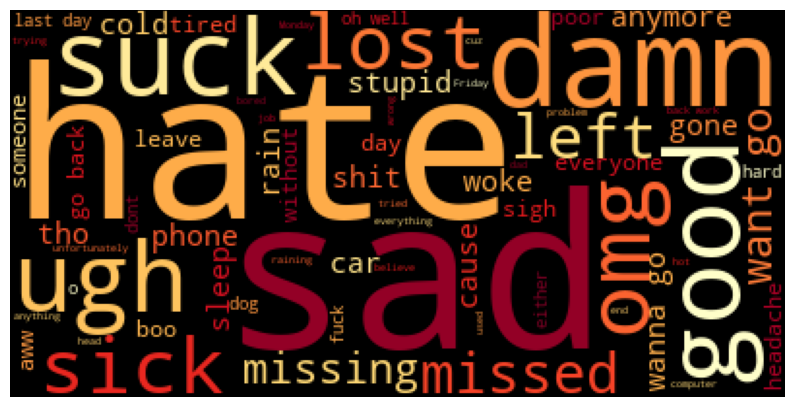

In [27]:
plt.figure(figsize=(10, 8))
plt.imshow(WordCloud(max_words=200, colormap='YlOrRd').generate_from_frequencies(pure_neg))   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
plt.axis('off')  #눈금 삭제 
plt.show()

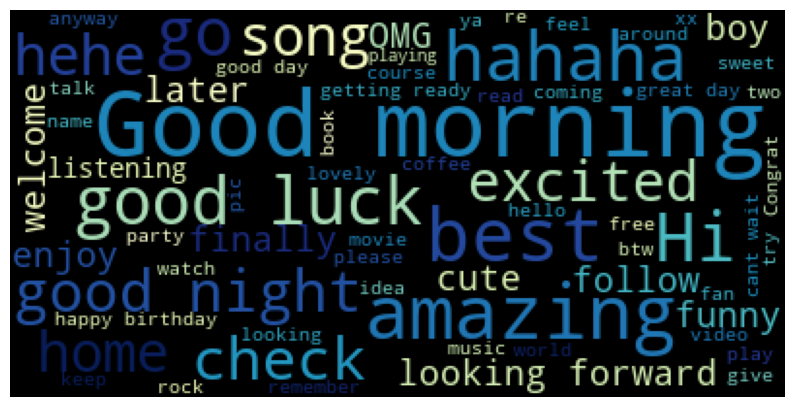

In [28]:
plt.figure(figsize=(10, 8))
plt.imshow(WordCloud(max_words=200, colormap='YlGnBu').generate_from_frequencies(pure_pos))   # wordcloud 객체를 넣으면 워드클라우드 형태의 그래프 생성
plt.axis('off')  #눈금 삭제 
plt.show()

In [3]:
!uv pip install newspaper3k

Using Python 3.11.11 environment at: /Users/admin/.pyenv/versions/3.11.11/envs/softeer-env
Resolved 27 packages in 1.35s                                        
Building jieba3k==0.35.1                                               
Building jieba3k==0.35.1                                       
Building tinysegmenter==0.3
Building jieba3k==0.35.1                                       
Building tinysegmenter==0.3
Building feedfinder2==0.0.4
Building jieba3k==0.35.1                                       
Building tinysegmenter==0.3
Building feedfinder2==0.0.4
Building sgmllib3k==1.0.0
Building jieba3k==0.35.1                                       
Building tinysegmenter==0.3
Building feedfinder2==0.0.4
Building sgmllib3k==1.0.0
⠙ Preparing packages... (0/13)
Building jieba3k==0.35.1---     0 B/4.14 KiB                   
Building tinysegmenter==0.3
Building feedfinder2==0.0.4
Building sgmllib3k==1.0.0
⠙ Preparing packages... (0/13)
Building jieba3k==0.35.1 4.14 KiB/4.14 KiB             